In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import random

file = open("weather_token.txt", "r")
weather_token = file.read()
file.close()

# Predicting bicycle traffic across Seattle's Fremont Bridge

Seattle's Fremont Bridge Dataset: Download the Fremont dataset from the [Seattle Open Data Portal](https://data.seattle.gov/)

### Gathering Bike traffic Data (Target Variable)

In [2]:
#Fremont bike traffic API

traffic_df_list = [] #list to gather returned api datasets
offset = 0 #initialize api offset
i = 0 #ensure the while true doesn't run forever if API changes

while True:
    i += 1
    
    url = f'https://data.seattle.gov/resource/65db-xm6k.json?$offset={str(offset)}'
    response = requests.get(url) # get website information
    df = pd.json_normalize(response.json()) # turn response into a pandas dataframe
    traffic_df_list.append(df) #append dataframe to list of previous api datasets
    offset += 1000 #increase offset to get new data

    if not response.json(): #if response is empty, we have reached the end of the dataset
        break

    if response.status_code != 200: # if the status code is not successful, stop
        print("Not a 200 Response Code")
        break
        
    time.sleep(1)
    
    if i == 500:
        print("Took too long")
        break

In [3]:
Fremont = pd.concat(traffic_df_list)

In [4]:
Fremont.head()

,date,fremont_bridge,fremont_bridge_nb,fremont_bridge_sb
0,2023-12-31T23:00:00.000,45,15,30
1,2023-12-31T22:00:00.000,22,12,10
2,2023-12-31T21:00:00.000,20,9,11
3,2023-12-31T20:00:00.000,27,14,13
4,2023-12-31T19:00:00.000,33,14,19


In [5]:
#dropping non-target variable
Fremont.drop(['fremont_bridge_nb','fremont_bridge_sb'],axis=1,inplace=True)

In [6]:
#renaming columns
Fremont.rename(columns={'fremont_bridge': 'Total'}, inplace = True)

In [7]:
Fremont.dtypes

date     object
Total    object
dtype: object

In [8]:
#changing dtypes
Fremont.date = pd.to_datetime(Fremont.date)
Fremont.Total = pd.to_numeric(Fremont.Total, errors='coerce')

In [9]:
#setting date as the index
Fremont.set_index('date', inplace = True)

In [10]:
print('The maximum date in the dataframe is', Fremont.index.max())
print('The minimum date in the dataframe is', Fremont.index.min())

The maximum date in the dataframe is 2023-12-31 23:00:00
The minimum date in the dataframe is 2012-10-02 13:00:00


<Axes: title={'center': 'Fremont Bridge bicycle traffic'}, xlabel='date'>

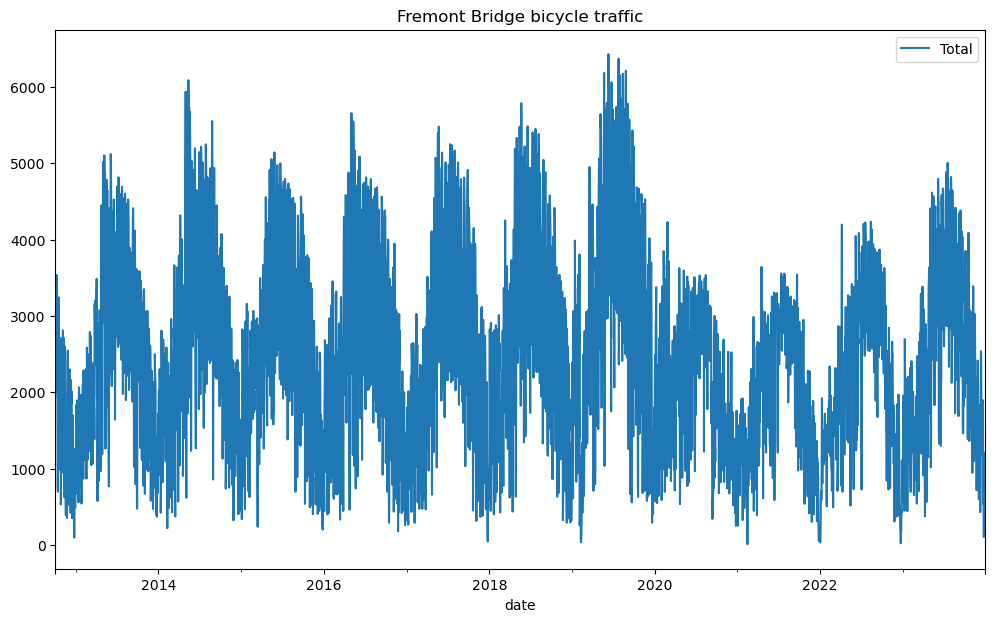

In [11]:
#plotting days, month, year
Fremont_daily = Fremont.resample('d').sum()
Fremont_daily[Fremont_daily.index == pd.to_datetime('2023-12-31')]
Fremont_daily.plot(figsize=(12,7), title = 'Fremont Bridge bicycle traffic')

The above graph shows bike traffic by date. There is obvious seasonality in the dataset. There is less bike traffic in the winter than the summer. The start of covid also reduced bike traffic in Fremont.

In [12]:
#extracting day of week and year variable
Fremont_daily['day_of_week'] = Fremont_daily.index.dayofweek
Fremont_daily['year'] = Fremont_daily.index.year

In [13]:
#add a holiday column
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012-10-03 00:00:00','2020-09-30')
Fremont_daily = Fremont_daily.join(pd.Series(1, index=holidays,name='holiday'))
Fremont_daily['holiday'].fillna(0, inplace=True)

In [14]:
#add a daylight seasonality column
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    'this function computes the hours of daylight for a particular date and latitude'
    days = (date-pd.to_datetime('2000-12-21')).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days*2*np.pi/365.25)))
    return 24.*np.degrees(np.arccos(1-np.clip(m,0,2,))) / 180

Fremont_daily['daylight_hrs'] = Fremont_daily.index.map(hours_of_daylight)

Text(0.5, 1.0, 'hours of daylight')

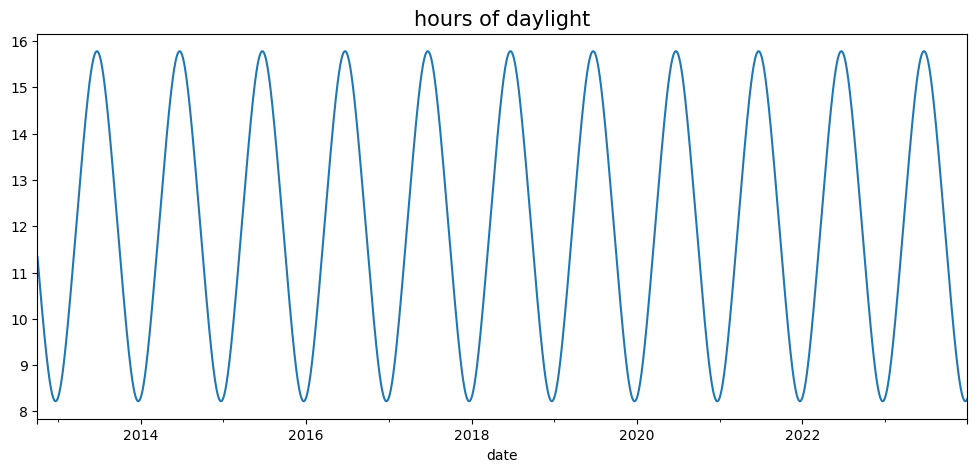

In [15]:
#showing daylight seasonality column. The winter has less daylight that the summer.
Fremont_daily.daylight_hrs.plot(figsize=(12,5))
plt.title('hours of daylight', fontsize=15)

## Weather dataset

Daily weather data from the [NOAA](https://www.ncdc.noaa.gov/cdo-web/search). Station ID: USW00024233 (SEATTLE TACOMA AIRPORT).

## Weather Feature selection

- ADPT = Average Dew Point Temperature for the day (tenths of degrees C)
- ASLP = Average Sea Level Pressure for the day (hPa * 10)
- ASTP = Average Station Level Pressure for the day (hPa * 10)
- AWBT = Average Wet Bulb Temperature for the day (tenths of degrees C)
- [x] AWND = Average daily wind speed
- [x] PRCP = Precipitation
- [x] RHAV = Average relative humidity for the day (percent)
- RHMN = Minimum relative humidity for the day (percent)
- RHMX = Maximum relative humidity for the day (percent)
- [x] SNOW = Snowfall 
- SNWD = Snow depth 
- [x] TAVG = Average temperature
- [x] TMAX = Maximum temperature
- [x] TMIN = Maximum temperature
- WDF2 = Direction of fastest 2-minute wind (degrees)
- WDF5 = Direction of fastest 5-second wind (degrees)
- [x] WSF2 = Fastest 2-minute wind speed (tenths of meters per second)
- WSF5 = Fastest 5-second wind speed (tenths of meters per second)
- WT01 = Weather Type Fog, ice fog, or freezing fog (may include heavy fog)
- WT02 = Weather Type Heavy fog or heaving freezing fog (not always distinquished from fog)
- WT03 = Weather Type Thunder
- WT04 = Weather Type Ice pellets, sleet, snow pellets, or small hail
- WT05 = Weather Type Hail (may include small hail)
- WT08 = Weather Type Smoke or haze
- WT13 = Weather Type Mist
- WT14 = Weather Type Drizzle
- WT16 = Weather Type Rain (may include freezing rain, drizzle, and freezing drizzle)

In [16]:
offset = 0 # API offset
i = 0 #iterations
start_date = pd.to_datetime('2018-10-01') #start date 
end_date = pd.to_datetime('2019-09-30') #end date of data. 1 year ahead due to api restrictions
weather_list = [] #list of weather dataframes

while True:
    i += 1 #adding to iterations
    
    str_start_date = start_date.strftime('%Y-%m-%d') #Start date to string for url
    str_end_date = end_date.strftime('%Y-%m-%d') #End date to string for url
    
    if start_date >= pd.to_datetime('today'): #If start date is ahead of today break.
        print('Done')
        break
        
    url = f'https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:USW00024233&units=standard&startdate={str_start_date}&enddate={str_end_date}&limit=1000&offset={offset}'
    #URL f-string with offset, start_date and end_date inputs.
    
    response = requests.get(url, headers={"user-agent": 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.5.2 Safari/605.1.15',"Token": weather_token})
    #get website information, headers add user agent and token
    
    try:
        weather = pd.json_normalize(response.json()['results']) #turn json object into pandas dataframe
        weather_list.append(weather) #append dataframe to dataframe list
        
        if response.json()['metadata']['resultset']['count'] > (offset + 1000): #1000 is the limit. add to the offset if there is remaining data
            offset += 1000
        else:
            start_date = start_date + pd.offsets.DateOffset(years=1) #if there are no additional information for that date add 1 year
            end_date = end_date + pd.offsets.DateOffset(years=1)# add a year to end date
            offset = 0 #reset offset
        
    except:
        print(response.status_code) # if error print response and
    
    if i == 200: #prevent the while statement from running forever
        print('iteration max')
        break
    
    time.sleep(random.randint(20, 60)) #prevent overloading the dataframe
    
    

503
503
503
503
503
Done


In [17]:
#joining dataframe list
weather = pd.concat(weather_list)

### Weather data exploration

In [18]:
pd.set_option('display.max_columns', None)
weather.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,ADPT,GHCND:USW00024233,",,W,",122.0
1,2018-10-01T00:00:00,ASLP,GHCND:USW00024233,",,W,",10102.0
2,2018-10-01T00:00:00,ASTP,GHCND:USW00024233,",,W,",9936.0
3,2018-10-01T00:00:00,AWBT,GHCND:USW00024233,",,W,",139.0
4,2018-10-01T00:00:00,AWND,GHCND:USW00024233,",,W,",8.3


In [19]:
weather.shape

(36218, 5)

In [20]:
weather.dtypes

date           object
datatype       object
station        object
attributes     object
value         float64
dtype: object

In [21]:
weather[weather.duplicated()]

,date,datatype,station,attributes,value
0,2018-11-22T00:00:00,RHMN,GHCND:USW00024233,",,W,",71.0
0,2019-11-21T00:00:00,WT08,GHCND:USW00024233,",,W,",1.0
0,2020-11-22T00:00:00,WSF5,GHCND:USW00024233,",,W,",19.0
0,2021-11-22T00:00:00,TMIN,GHCND:USW00024233,",,W,2400",34.0
0,2022-11-22T00:00:00,PRCP,GHCND:USW00024233,",,W,2400",1.2
0,2023-11-22T00:00:00,SNWD,GHCND:USW00024233,",,W,",0.0


In [22]:
#Removing API error duplicates.
weather = weather[~weather.duplicated()]

In [23]:
#group weather indicator by day
weather = weather.pivot(index='date', columns='datatype', values='value')

In [24]:
#filtering to columns I want to use.
weather = weather[['AWND','PRCP','RHAV','SNOW','TAVG','TMAX','TMIN','WSF2']]

In [25]:
#Change format for join later
weather.index = pd.to_datetime(weather.index)

In [26]:
#Fix pivot column header levels
weather = weather.reset_index().rename_axis(None, axis=1).set_index('date')

<Axes: xlabel='date'>

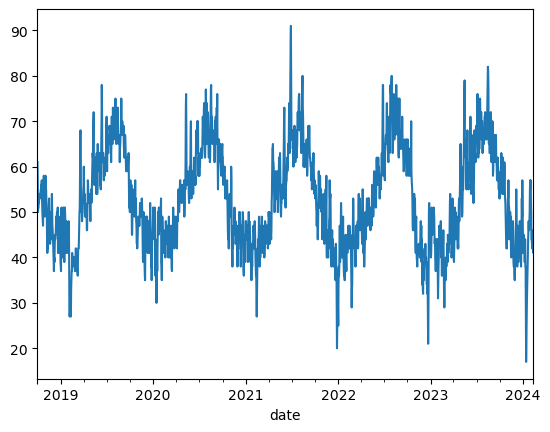

In [27]:
# Showing average tempature
weather.TAVG.plot()

<Axes: xlabel='date'>

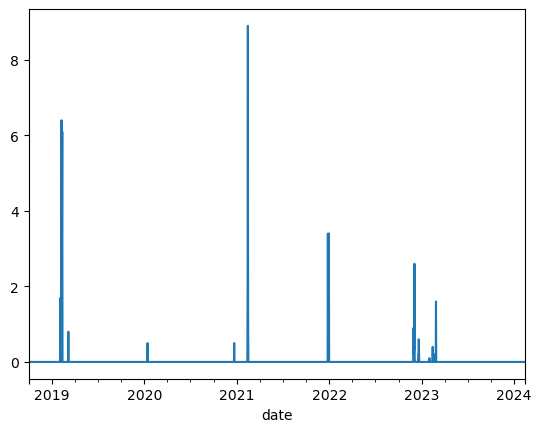

In [28]:
#showing snow throughout the year
weather.SNOW.plot()

<Axes: xlabel='date'>

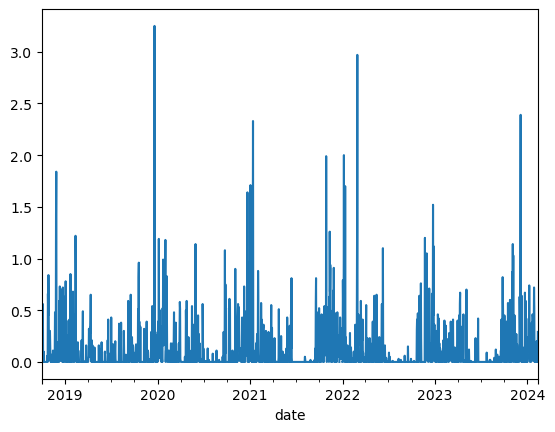

In [29]:
# graphing precipitation
weather.PRCP.plot()

## Merge weather and daily traffic datasets

In [30]:
#joining both dataframes. Both have a date index
daily = weather.join(Fremont_daily, how='inner')

In [31]:
#removing null rows
daily = daily[~daily.isnull().any(axis=1)]

In [32]:
#renaming target column
daily.rename(columns = {'Total' : 'actual'}, inplace = True)

In [33]:
#seperating covid years into its own dataframe
covid_2020 = daily[(daily.index>=pd.to_datetime('2020/01/01')) & (daily.index<=pd.to_datetime('2020/12/31'))]

## Model

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [35]:
#defining X and Y
X = daily[['AWND', 'PRCP', 'RHAV', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'WSF2', 'day_of_week', 'year', 'holiday', 'daylight_hrs']]
y = daily[['actual']]

In [36]:
#splitting training and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [37]:
# categorical processor
cat_features = ['day_of_week','holiday']
cat_processor = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

# numerical processor
num_features = ['year','daylight_hrs','AWND', 'PRCP', 'RHAV', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'WSF2']
num_processor = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# preprocessor
processor = ColumnTransformer(transformers=[
    ('cat_processor',cat_processor,cat_features),
    ('num_processor',num_processor,num_features)
])

# pipeline
pipe = Pipeline(steps=[
    ('preprocessor',processor),
    ('poly_features',PolynomialFeatures(include_bias=False)),
    ('reg', Ridge())
])

In [38]:
#establishing parameters
parameters = {
    'reg__alpha' : [0.0001, 0.001,0.01,0.1,1,10,100],
    'poly_features__degree' : [1,2,3,4]
}

In [39]:
# Grid Search
grid = GridSearchCV(pipe,parameters,cv=10,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=True)

In [40]:
#fitting grid
grid.fit(X_train,y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_processor',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['day_of_week',
                                                                          'holiday']),
                                                                        ('num_processor',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['year',
                                                                          'daylight_hrs',
                                                                          'AWND',
                                                                          'PRCP',
                                                                          'RHAV',
                                                                          'SNOW',
                                                                          'TAVG',
                                                                          'TMAX',
                                                                          'TMIN',
                                                                          'WSF2'])])),
                                       ('poly_features',
                                        PolynomialFeatures(include_bias=False)),
                                       ('reg', Ridge())]),
             n_jobs=-1,
             param_grid={'poly_features__degree': [1, 2, 3, 4],
                         'reg__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [41]:
#grids best parameters
grid.best_params_

{'poly_features__degree': 4, 'reg__alpha': 1}

In [42]:
# predicting y_test variables
y_test_pred = grid.predict(X_test)

In [43]:
#showing best cross validation results
results = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'params']]
results.head()

,mean_test_score,params
0,-785.626670,"{'poly_features__degree': 1, 'reg__alpha': 0.0..."
1,-785.623587,"{'poly_features__degree': 1, 'reg__alpha': 0.001}"
2,-785.594364,"{'poly_features__degree': 1, 'reg__alpha': 0.01}"
3,-785.421355,"{'poly_features__degree': 1, 'reg__alpha': 0.1}"
4,-785.882687,"{'poly_features__degree': 1, 'reg__alpha': 1}"


In [44]:
#root mean squared error
np.sqrt(mean_squared_error(y_test,y_test_pred))

581.9878140124379

Text(0.5, 1.0, 'negative root mean squared error')

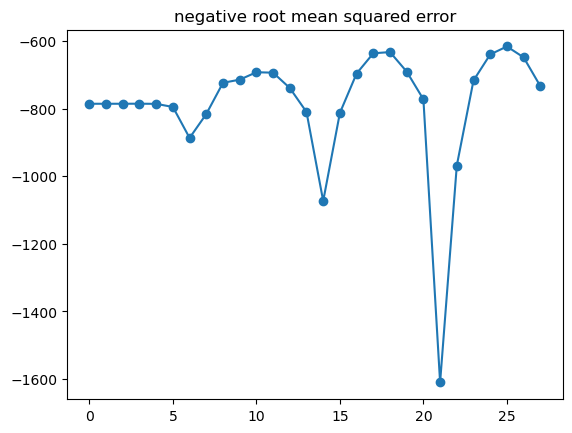

In [45]:
#plotting negative root mean squared error against
results.mean_test_score.plot(marker='o')
plt.title('negative root mean squared error')

In [46]:
#Params (X-axis) for above graph
results.params

0     {'poly_features__degree': 1, 'reg__alpha': 0.0...
1     {'poly_features__degree': 1, 'reg__alpha': 0.001}
2      {'poly_features__degree': 1, 'reg__alpha': 0.01}
3       {'poly_features__degree': 1, 'reg__alpha': 0.1}
4         {'poly_features__degree': 1, 'reg__alpha': 1}
5        {'poly_features__degree': 1, 'reg__alpha': 10}
6       {'poly_features__degree': 1, 'reg__alpha': 100}
7     {'poly_features__degree': 2, 'reg__alpha': 0.0...
8     {'poly_features__degree': 2, 'reg__alpha': 0.001}
9      {'poly_features__degree': 2, 'reg__alpha': 0.01}
10      {'poly_features__degree': 2, 'reg__alpha': 0.1}
11        {'poly_features__degree': 2, 'reg__alpha': 1}
12       {'poly_features__degree': 2, 'reg__alpha': 10}
13      {'poly_features__degree': 2, 'reg__alpha': 100}
14    {'poly_features__degree': 3, 'reg__alpha': 0.0...
15    {'poly_features__degree': 3, 'reg__alpha': 0.001}
16     {'poly_features__degree': 3, 'reg__alpha': 0.01}
17      {'poly_features__degree': 3, 'reg__alpha

In [47]:
# predicting all x varibales
daily['predicted'] = grid.predict(X)

Text(0.5, 1.0, 'daily traffic')

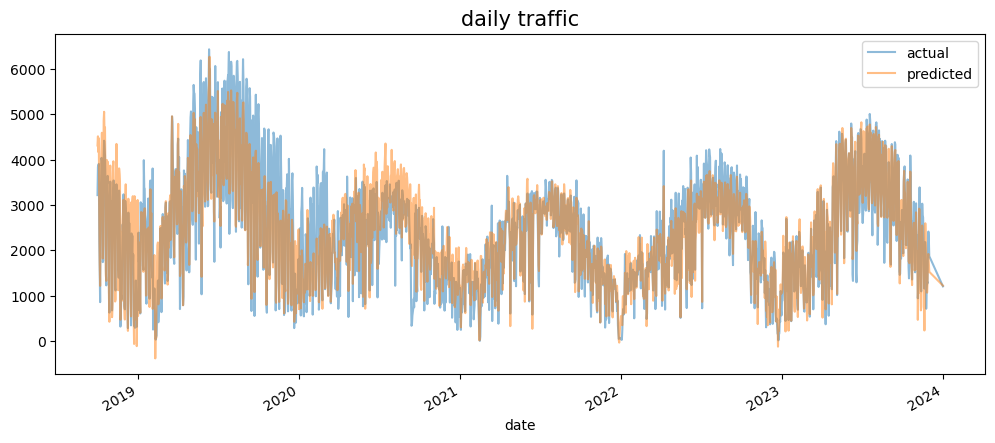

In [48]:
# plot actual and predicted values
daily[['actual','predicted']].plot(alpha=0.5, figsize=(12,5))
plt.title('daily traffic',fontsize=15)

Text(0.5, 1.0, 'Freemont Bridge Traffic')

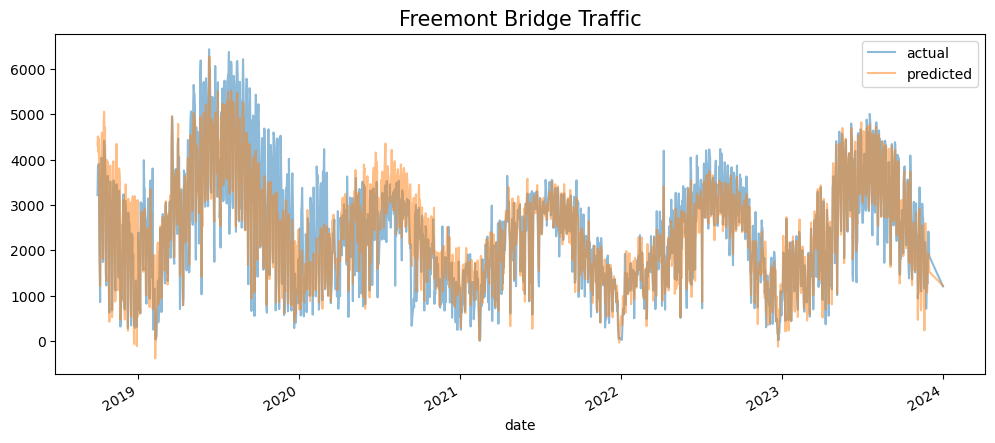

In [49]:
# plot actual and predicted values
daily[['actual','predicted']].plot(alpha=0.5, figsize=(12,5))
plt.title('Freemont Bridge Traffic',fontsize=15)

Text(0.5, 1.0, 'monthly traffic')

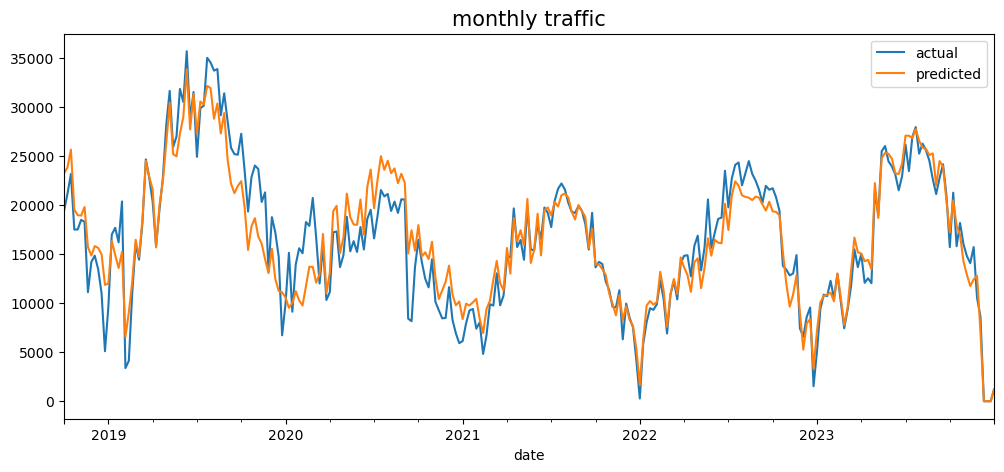

In [50]:
#plot actual and predicted monthly values
daily[['actual','predicted']].resample('W').sum().plot(figsize=(12,5))
plt.title('monthly traffic',fontsize=15)

**Model coefficients**

In [51]:
# feature names
encoded_feature_names = grid.best_estimator_['preprocessor'].named_transformers_['cat_processor']['encoder'].get_feature_names_out(cat_features)
feature_names = list(encoded_feature_names)+num_features
feature_names = grid.best_estimator_['poly_features'].get_feature_names_out(feature_names)

In [52]:
#coefficients
coefficients = grid.best_estimator_['reg'].coef_[0]
coeff_df = pd.DataFrame(coefficients, feature_names, columns=['coefficient'])

In [53]:
top_bottom_coeff = pd.concat([coeff_df.sort_values(by='coefficient').tail(50), coeff_df.sort_values(by='coefficient').head(50)]).sort_values(by='coefficient')

<Axes: >

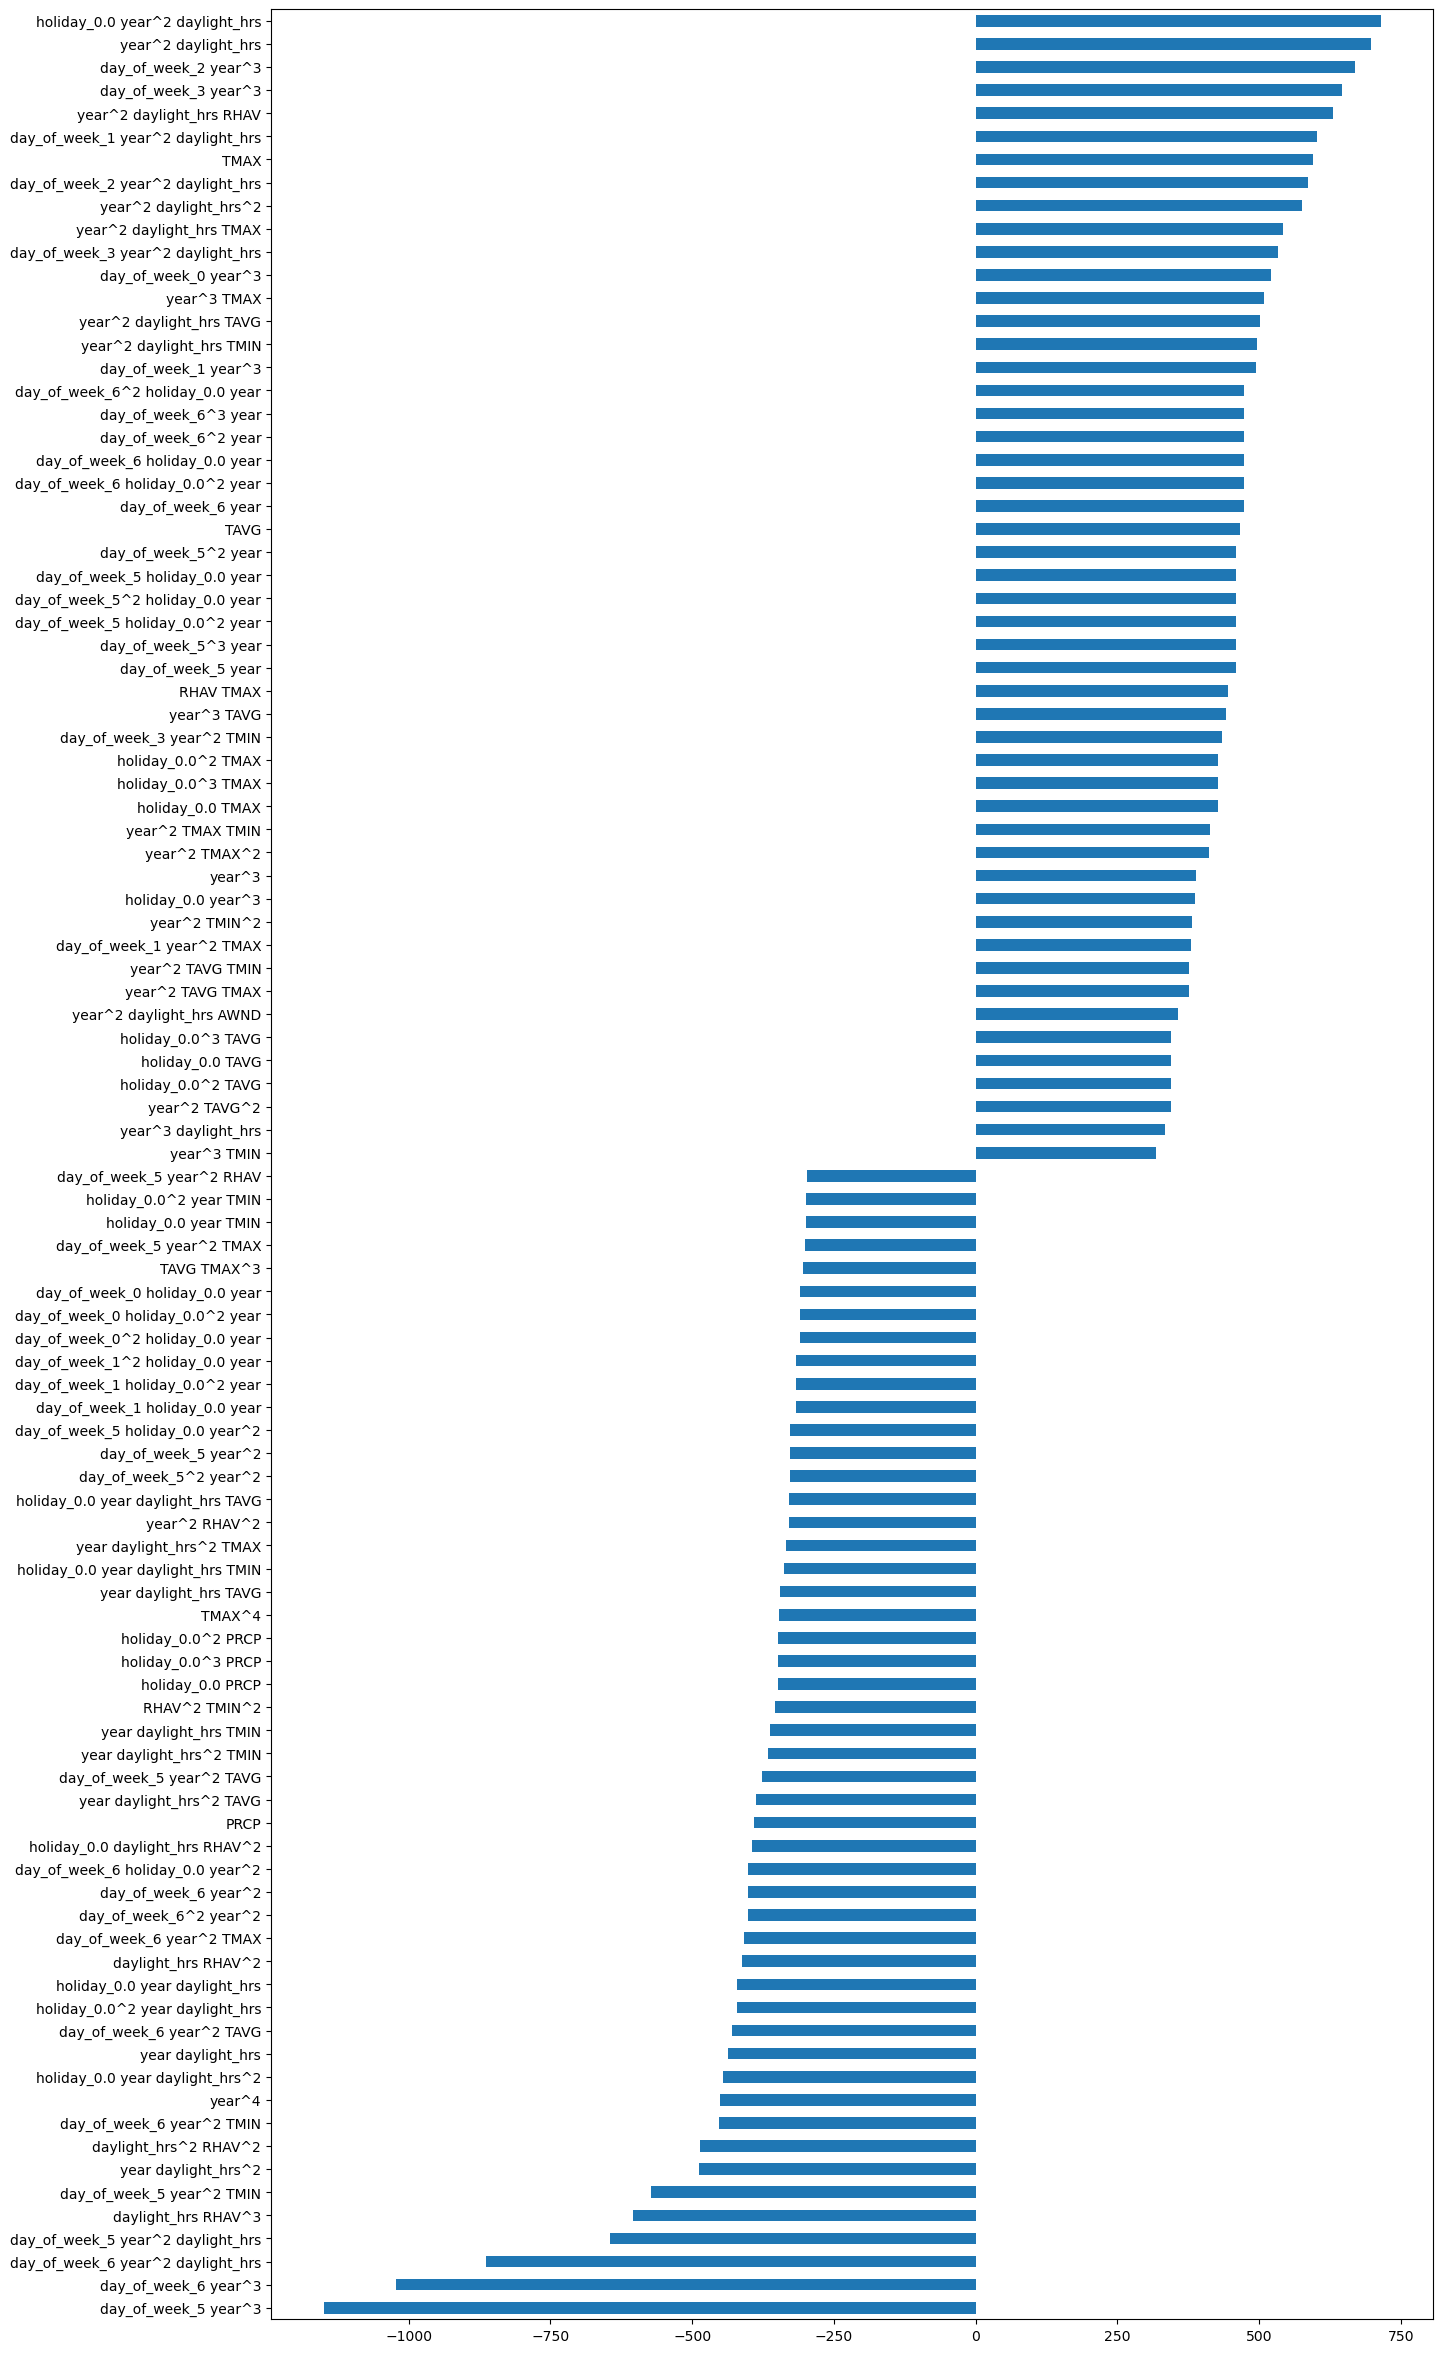

In [54]:
plt.figure(figsize=(12,10))
top_bottom_coeff.coefficient.plot(kind='barh',figsize=(15,30))

## What would 2020 look like without Covid?

In [55]:
#define covid varibales
y_2020 = covid_2020['actual'] # target vector
X_2020 = covid_2020.drop('actual', axis = 1) # feature matrix

In [56]:
#predicting what bike traffic would be without covid
covid_2020['predicted_ridge'] = grid.predict(X_2020)

/var/folders/t6/09cczzd97c5cmtwrw_26_0wh0000gn/T/ipykernel_4462/3794135791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_2020['predicted_ridge'] = grid.predict(X_2020)


Text(0.5, 1.0, '2020 daily traffic')

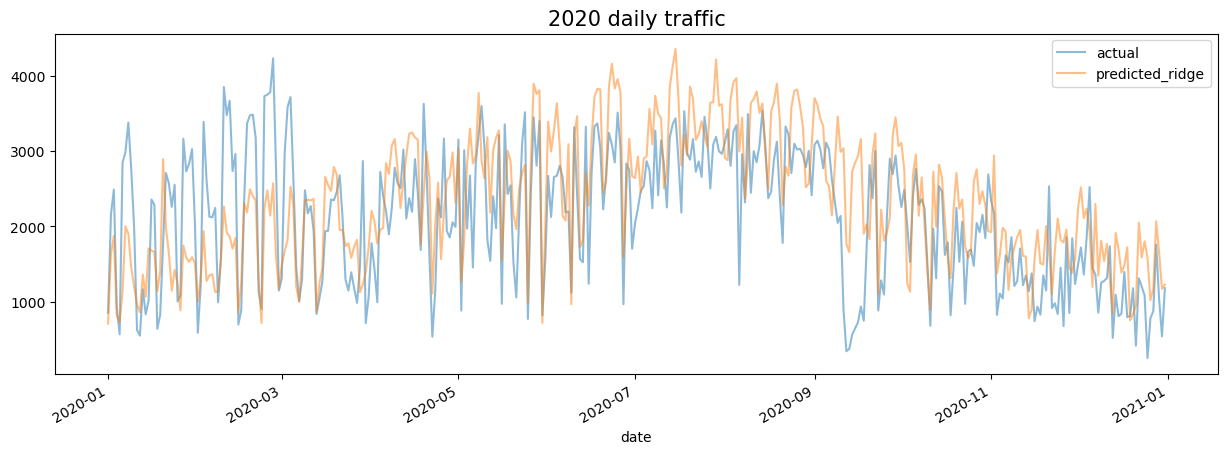

In [57]:
# plot actual and predicted values
covid_2020[['actual','predicted_ridge']].plot(alpha=0.5, figsize=(15,5))
plt.title('2020 daily traffic',fontsize=15)